# Jina Embeddings v3

### Imports

In [1]:
# # Install necessary libraries if not already installed
# !pip install --upgrade torch torchvision
# !pip install flash-attn --no-build-isolation

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import plotly.graph_objects as go
from pathlib import Path
from sentence_transformers import SentenceTransformer
from sklearn.cluster import KMeans
from sklearn.metrics.pairwise import cosine_similarity
from bs4 import BeautifulSoup
import random
import umap


## Stap 1: Data inladen en previewen

In [3]:

# Inlezen van feather-bestand vanuit /content
df_raw = pd.read_feather(r"E:\Nieuw dataset\Dutch news articles 2015-2025 NOS.nl\NOS_NL_articles_2015_mar_2025.feather")

# Preview van de kolommen
print(df_raw.columns)

display(df_raw)


Index(['channel', 'url', 'type', 'title', 'keywords', 'section', 'description',
       'published_time', 'modified_time', 'image', 'content'],
      dtype='object')


,channel,url,type,title,keywords,section,description,published_time,modified_time,image,content
1948,nos,https://nos.nl/artikel/2011341-euro-nu-ook-in-...,article,Euro nu ook in Litouwen,eurozone,Economie,Vanaf vandaag betalen ze in Litouwen met de eu...,2015-01-01 00:32:52,2015-01-01 00:32:52,https://cdn.nos.nl/image/2015/01/01/48809/1200...,<h1>Euro nu ook in Litouwen</h1><p>In Litouwen...
1949,nos,https://nos.nl/artikel/2011343-start-2015-vol-...,article,Start 2015 vol vreugde maar ook met gewonden e...,oud en nieuw,Binnenland,Nederland is met oliebollen en vuurwerk het ni...,2015-01-01 01:05:57,2015-01-01 07:18:23,https://cdn.nos.nl/image/2015/01/01/48853/1200...,<h1>Start 2015 vol vreugde maar ook met gewond...
1950,nos,https://nos.nl/artikel/2011346-letland-nieuwe-...,article,Letland nieuwe voorzitter van de Europese Unie,"EU-voorzitter, Italië, EU, Letland",Buitenland,Vanaf vandaag neemt Letland het stokje over va...,2015-01-01 02:32:34,2015-01-01 02:32:34,https://cdn.nos.nl/image/2015/01/01/48818/1200...,<h1>Letland nieuwe voorzitter van de Europese ...
1951,nos,https://nos.nl/artikel/2011348-noord-korea-wil...,article,Noord-Korea wil praten met Zuid-Korea,"kim jong un, Noord-Korea, Zuid-Korea",Buitenland,De Noord-Koreaanse leider Kim Jong-un zei in z...,2015-01-01 03:34:25,2015-01-01 03:34:25,https://cdn.nos.nl/image/2014/12/24/42888/1200...,<h1>Noord-Korea wil praten met Zuid-Korea</h1>...
1952,nos,https://nos.nl/artikel/2011351-feest-in-londen...,article,"Feest in Londen, Parijs en Berlijn",jaarwisseling,Buitenland,In Londen en Berlijn waren muziekfestivals. Pa...,2015-01-01 04:34:20,2015-01-01 04:34:20,https://cdn.nos.nl/image/2015/01/01/48846/1200...,"<h1>Feest in Londen, Parijs en Berlijn</h1><p>..."
...,...,...,...,...,...,...,...,...,...,...,...
1928,nos,https://nos.nl/l/2561877,article,Gorré kijkt terug op historische prestatie met...,"voetbal, Suriname, Natio",Voetbal,Dean Gorré leidde het voetbalteam van Suriname...,2025-03-31 22:27:34,2025-03-31 22:27:34,https://cdn.nos.nl/image/2025/03/31/1209242/10...,<h1>Gorré kijkt terug op historische prestatie...
1929,nos,https://nos.nl/l/2561881,article,Rode Kruis woedend over doden hulpverleners in...,"hulpverleners, Rafah, Gaza",Buitenland,Gisteren werden de lichamen van vijftien hulpv...,2025-03-31 22:30:12,2025-03-31 22:30:12,https://cdn.nos.nl/image/2025/03/31/1209248/10...,<h1>Rode Kruis woedend over doden hulpverlener...
1930,nos,https://nos.nl/l/2561883,article,Politie doet inval in Enschede in zoektocht na...,"ontvoering, Amber Alert, politie, Enschede, Da...",Regionaal nieuws,Buurtbewoners zeggen dat de politie onderzoek ...,2025-03-31 23:01:55,2025-03-31 23:01:55,https://cdn.nos.nl/image/2025/03/31/1209252/10...,<h1>Politie doet inval in Enschede in zoektoch...
1931,nos,https://nos.nl/l/2561884,article,Meerdere voertuigen over de kop op snelweg bij...,"A50, ongeluk, Vaassen, Epe, Zwolle",Binnenland,Volgens Omroep Gelderland is er een onbekend a...,2025-03-31 23:28:12,2025-03-31 23:28:12,https://cdn.nos.nl/image/2025/03/31/1209258/10...,<h1>Meerdere voertuigen over de kop op snelweg...


In [4]:
# Count the occurrences of specific channels
channel_counts = df_raw['channel'].value_counts()

# Print counts for 'nos', 'nieuwsuur', and 'liveblogs'
print(f"NOS articles: {channel_counts.get('nos', 0)}")
print(f"Nieuwsuur' aricles: {channel_counts.get('nieuwsuur', 0)}")
print(f"liveblogs: {channel_counts.get('liveblog', 0)}")


# Check for duplicates
duplicate_count = df_raw.duplicated().sum()
print(f"Number of duplicate rows: {duplicate_count}")

# Check for missing values
missing_values = df_raw.isnull().sum()
print("Missing values per column:")
print(missing_values)

NOS articles: 285210
Nieuwsuur' aricles: 10049
liveblogs: 0
Number of duplicate rows: 0
Missing values per column:
channel               0
url                   0
type                  0
title                 0
keywords          15473
section            5524
description           0
published_time        0
modified_time         0
image               101
content               0
dtype: int64


> Pick a random article from the dataframe

In [5]:

random_index = random.randint(0, len(df_raw) - 1)

# Select the row at the random index and extract the desired columns
random_article = df_raw.iloc[random_index][['title', 'content', 'published_time', 'url']]

# Print the selected article's title and content
print(f"Title: {random_article['title']}")
print(f"Content: {random_article['content']}")
print(f"Published Time: {random_article['published_time']}")
print(f"URL: {random_article['url']}")

Title: Vaccineren alleen is niet genoeg om apenpokkenvirus in de kiem te smoren
Content: <h1>Vaccineren alleen is niet genoeg om apenpokkenvirus in de kiem te smoren</h1><p>Vaccineren alleen is niet voldoende om het apenpokkenvirus onder controle te krijgen, zeggen de RIVM en de GGD in Amsterdam en Den Haag tegen de NOS.</p><p>Het virus gaat vrijwel exclusief rond onder mannen die geregeld seks hebben met wisselende mannelijke partners. Het wordt voornamelijk doorgegeven tijdens langdurig en intensief huid-op-huid contact tijdens seks.</p><p>Deskundigen adviseren tijdelijk het aantal sekspartners te beperken om de verspreiding van het virus te temperen. Dat beschermt de gezondheid van deze mensen, en houdt de kans zo klein mogelijk dat het virus zich breder verspreidt.</p><p>Zo denken mensen bij de RAI, waar gevaccineerd wordt, over een prik:</p><p>Het RIVM heeft een landelijke lijst met 32.000 mensen opgesteld die veel risico lopen. Het gaat om homoseksuele of transgender mensen die o

Looks good, only content is in HTML format. lets need to clean it up a bit.


## Step 2: Data cleaning 
- Parse and clean the HTML content
- set datetime to yy-mm-dd format
- select articles from 2015-01 to 2025-01


#### Parse and clean the HTML content

####  Convert 'published_time' to datetime

In [6]:
# Stap 1: Convert 'published_time' to datetime
df_raw['published_time'] = pd.to_datetime(df_raw['published_time'])

#### select artocles from 2015-01 to 2025-01


In [7]:
# Stap 2: Filter op datum
start_date = '2015-01-01'
end_date = '2025-01-31'
filtered_df = df_raw[(df_raw['published_time'] >= start_date) & (df_raw['published_time'] <= end_date)].copy()

In [8]:
# Stap 3: Format 'published_time' naar string voor presentatie (yyyy/mm/dd)
filtered_df['published_time'] = filtered_df['published_time'].dt.strftime('%Y/%m/%d')

# Preview
print(filtered_df[['published_time']].head())

     published_time
1948     2015/01/01
1949     2015/01/01
1950     2015/01/01
1951     2015/01/01
1952     2015/01/01


#### Parse and clean the HTML content

In [9]:

# Stap 2: Selecteer relevante kolommen
filtered_df = filtered_df[['published_time', 'title', 'description', 'content', 'url', 'channel']]

# Stap 3: Clean HTML in 'content'
def clean_html(raw_html):
    soup = BeautifulSoup(raw_html, 'html.parser')
    return soup.get_text(separator=' ', strip=True)

filtered_df['content'] = filtered_df['content'].apply(clean_html)

####  save as  CSV

In [10]:
# Stap 4: Opslaan als CSV
output_path = r"E:\Nieuw dataset\Dutch news articles 2015-2025 NOS.nl\articles_cleaned.csv"
filtered_df.to_csv(output_path, index=False, encoding='utf-8-sig')

print(f"Dataset saved: {output_path}")

Dataset saved: E:\Nieuw dataset\Dutch news articles 2015-2025 NOS.nl\articles_cleaned.csv


#### Start with new CSV

In [2]:
df_csv = pd.read_csv(r"E:\Nieuw dataset\Dutch news articles 2015-2025 NOS.nl\articles_cleaned.csv")
df_csv.head()

,published_time,title,description,content,url,channel
0,2015/01/01,Euro nu ook in Litouwen,Vanaf vandaag betalen ze in Litouwen met de eu...,Euro nu ook in Litouwen In Litouwen wordt vana...,https://nos.nl/artikel/2011341-euro-nu-ook-in-...,nos
1,2015/01/01,Start 2015 vol vreugde maar ook met gewonden e...,Nederland is met oliebollen en vuurwerk het ni...,Start 2015 vol vreugde maar ook met gewonden e...,https://nos.nl/artikel/2011343-start-2015-vol-...,nos
2,2015/01/01,Letland nieuwe voorzitter van de Europese Unie,Vanaf vandaag neemt Letland het stokje over va...,Letland nieuwe voorzitter van de Europese Unie...,https://nos.nl/artikel/2011346-letland-nieuwe-...,nos
3,2015/01/01,Noord-Korea wil praten met Zuid-Korea,De Noord-Koreaanse leider Kim Jong-un zei in z...,Noord-Korea wil praten met Zuid-Korea De Noord...,https://nos.nl/artikel/2011348-noord-korea-wil...,nos
4,2015/01/01,"Feest in Londen, Parijs en Berlijn",In Londen en Berlijn waren muziekfestivals. Pa...,"Feest in Londen, Parijs en Berlijn In Europa i...",https://nos.nl/artikel/2011351-feest-in-londen...,nos


In [12]:

random_article = df_csv.iloc[random_index][['title', 'content', 'published_time', 'url']]

# Print the selected article's title and content
print(f"Title: {random_article['title']}")
print(f"Content: {random_article['content']}")
print(f"Published Time: {random_article['published_time']}")
print(f"URL: {random_article['url']}")

Title: Vaccineren alleen is niet genoeg om apenpokkenvirus in de kiem te smoren
Content: Vaccineren alleen is niet genoeg om apenpokkenvirus in de kiem te smoren Vaccineren alleen is niet voldoende om het apenpokkenvirus onder controle te krijgen, zeggen de RIVM en de GGD in Amsterdam en Den Haag tegen de NOS. Het virus gaat vrijwel exclusief rond onder mannen die geregeld seks hebben met wisselende mannelijke partners. Het wordt voornamelijk doorgegeven tijdens langdurig en intensief huid-op-huid contact tijdens seks. Deskundigen adviseren tijdelijk het aantal sekspartners te beperken om de verspreiding van het virus te temperen. Dat beschermt de gezondheid van deze mensen, en houdt de kans zo klein mogelijk dat het virus zich breder verspreidt. Zo denken mensen bij de RAI, waar gevaccineerd wordt, over een prik: Het RIVM heeft een landelijke lijst met 32.000 mensen opgesteld die veel risico lopen. Het gaat om homoseksuele of transgender mensen die om een hiv-infectie te voorkomen het

In [13]:
channel_counts = df_csv['channel'].value_counts()

# Print counts for 'nos', 'nieuwsuur', and 'liveblogs'
print(f"NOS articles: {channel_counts.get('nos', 0)}")
print(f"Nieuwsuur' aricles: {channel_counts.get('nieuwsuur', 0)}")
print(f"liveblogs: {channel_counts.get('liveblog', 0)}")

NOS articles: 281426
Nieuwsuur' aricles: 10049
liveblogs: 0


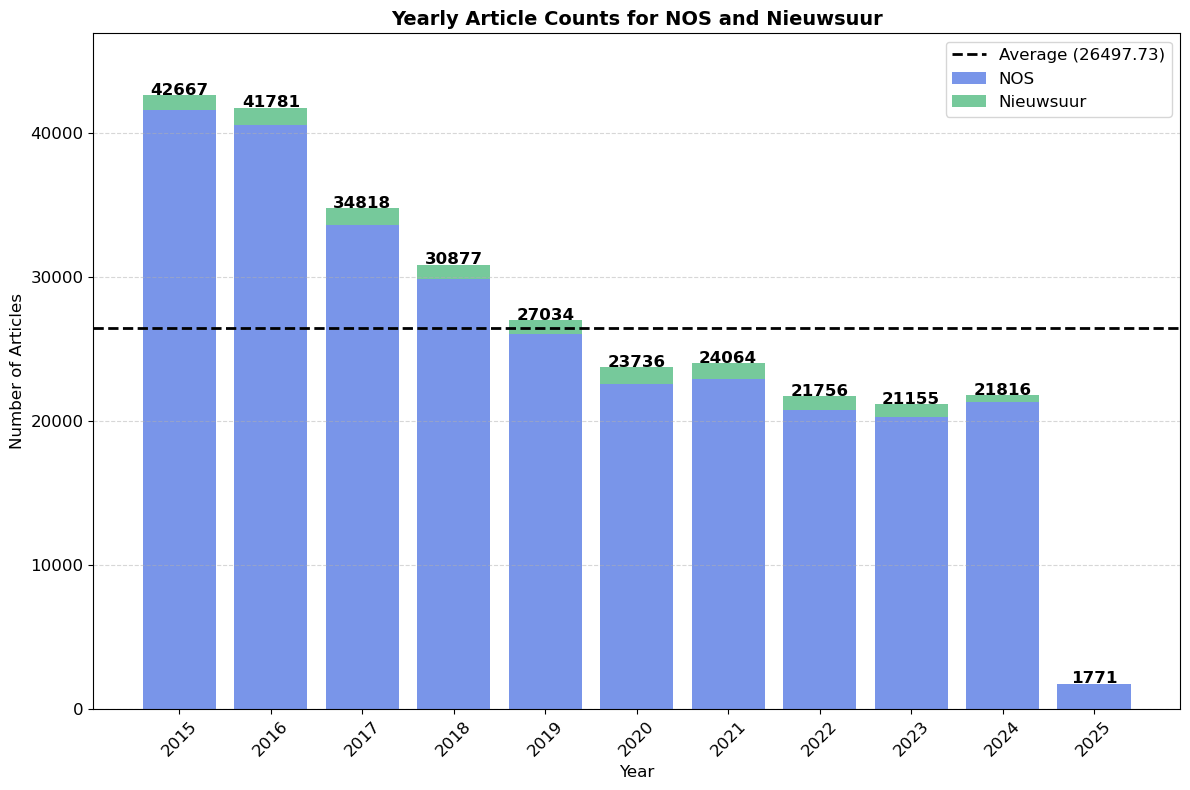

In [15]:
# # Convert 'published_time' to datetime if not already done
# df_csv['published_time'] = pd.to_datetime(df_csv['published_time'], format='%y-%m-%d')

# Ensure 'published_time' is in datetime format
df_csv['published_time'] = pd.to_datetime(df_csv['published_time'], format='%Y/%m/%d', errors='coerce')

# Extract year from 'published_time'
df_csv['year'] = df_csv['published_time'].dt.year

# Group by year and channel, then count articles
articles_per_year = df_csv.groupby(['year', 'channel']).size().unstack(fill_value=0)

# Calculate total articles per year
articles_per_year['total'] = articles_per_year.sum(axis=1)

# Calculate average articles per year
average_articles_per_year = articles_per_year['total'].mean()

# Plot stacked bar chart with increased y-axis limit
plt.figure(figsize=(12, 8))
bars_nos = plt.bar(articles_per_year.index, articles_per_year['nos'], color='royalblue', label="NOS", alpha=0.7)
bars_nieuwsuur = plt.bar(articles_per_year.index, articles_per_year['nieuwsuur'], bottom=articles_per_year['nos'], color='mediumseagreen', label="Nieuwsuur", alpha=0.7)

# Add text labels for total count on top of each bar
for i, total in enumerate(articles_per_year['total']):
    plt.text(articles_per_year.index[i], total + 5, int(total), ha='center', fontsize=12, fontweight='bold')

# Add average line
plt.axhline(y=average_articles_per_year, color='black', linestyle='dashed', linewidth=2, label=f'Average ({average_articles_per_year:.2f})')

# Labels and title
plt.title("Yearly Article Counts for NOS and Nieuwsuur", fontsize=14, fontweight="bold")
plt.xlabel("Year", fontsize=12)
plt.ylabel("Number of Articles", fontsize=12)
plt.xticks(articles_per_year.index, rotation=45, fontsize=12)
plt.yticks(fontsize=12)
plt.legend(fontsize=12)
plt.grid(axis='y', linestyle="--", alpha=0.5)
max_total = articles_per_year['total'].max()
plt.ylim(0, max_total * 1.1)  # 10% extra margin above the highest point
plt.tight_layout()

# Show the plot
plt.show()

# Calculate total articles
total_articles = articles_per_year['total'].sum()


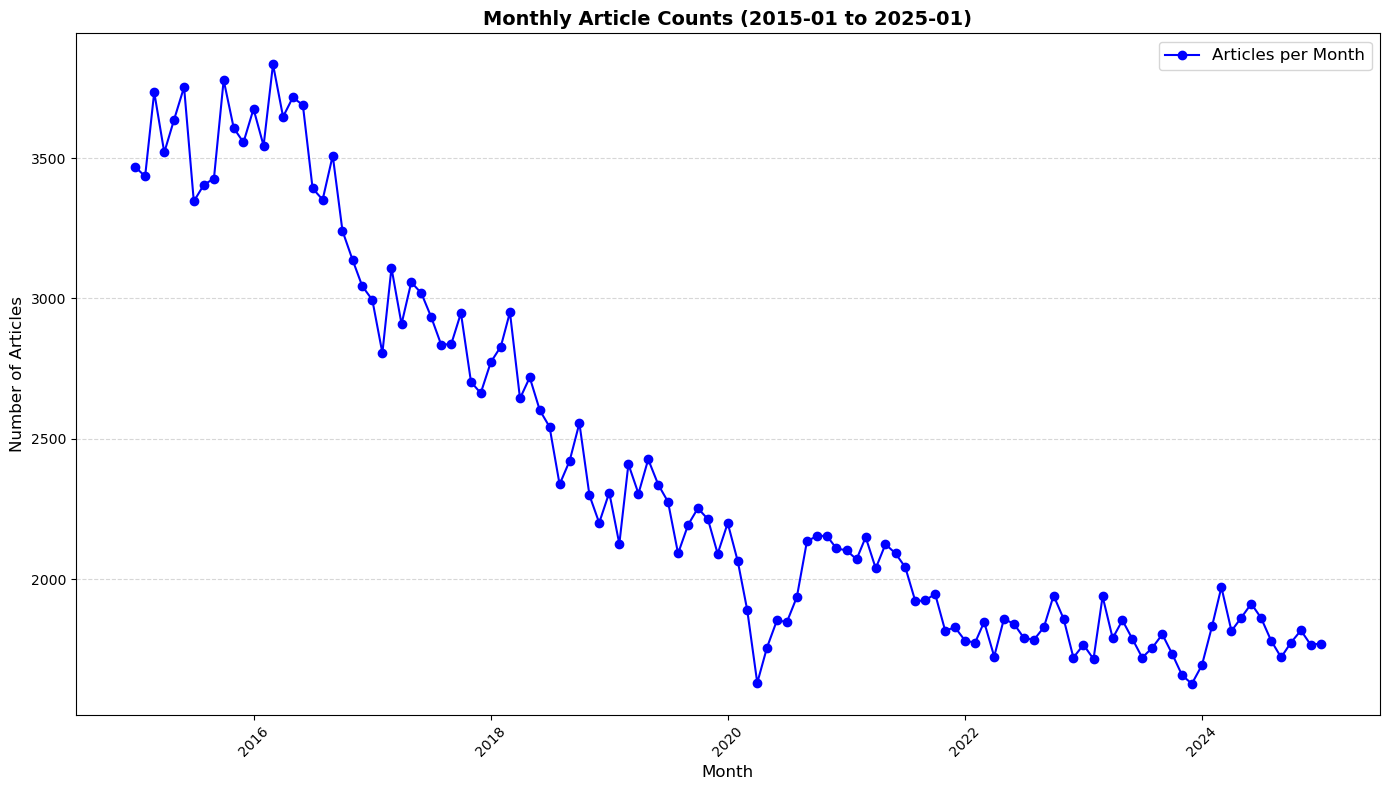

In [17]:
# Convert 'published_time' to datetime if not already done
df_csv['published_time'] = pd.to_datetime(df_csv['published_time'], format='%Y/%m/%d', errors='coerce')

# Extract year and month from 'published_time'
df_csv['year_month'] = df_csv['published_time'].dt.to_period('M')

# Group by year and month, then count articles
articles_per_month = df_csv.groupby('year_month').size()

# Convert the index back to datetime for plotting
articles_per_month.index = articles_per_month.index.to_timestamp()

# Plot the line chart
plt.figure(figsize=(14, 8))
plt.plot(articles_per_month.index, articles_per_month.values, marker='o', color='blue', label='Articles per Month')

# Add labels and title
plt.title("Monthly Article Counts (2015-01 to 2025-01)", fontsize=14, fontweight="bold")
plt.xlabel("Month", fontsize=12)
plt.ylabel("Number of Articles", fontsize=12)
plt.xticks(rotation=45, fontsize=10)
plt.yticks(fontsize=10)
plt.grid(axis='y', linestyle="--", alpha=0.5)
plt.legend(fontsize=12)
plt.tight_layout()

# Show the plot
plt.show()

In [16]:
# Calculate the total number of months in the dataset
total_months = len(pd.date_range(start=start_date, end=end_date, freq='M'))

# Calculate the average articles per month
average_articles_per_month = total_articles / total_months

print(f"Average articles per month: {average_articles_per_month:.2f}")

Average articles per month: 2408.88


C:\Users\dylan\AppData\Local\Temp\ipykernel_14424\722606589.py:2: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  total_months = len(pd.date_range(start=start_date, end=end_date, freq='M'))


 ## Jina Embeddings V3

#### Superkleine batch draaien

In [3]:
from sentence_transformers import SentenceTransformer

# Model laden
model = SentenceTransformer("jinaai/jina-embeddings-v3", trust_remote_code=True)

# Combineer 'title', 'description' en 'content'
df_csv['combined_text'] = df_csv['title'].fillna('') + ". " + df_csv['description'].fillna('') + ". " + df_csv['content'].fillna('')

# Pak klein batchje (bijv. 5)
texts = df_csv['combined_text'].head(10).tolist()

# Embeddings genereren zoals eerder
embeddings = model.encode(texts, task='retrieval.passage', batch_size=2, show_progress_bar=True)


print(embeddings.shape)  # Zou (5, 1024) moeten zijn


Batches:   0%|          | 0/5 [00:00<?, ?it/s]

(10, 1024)


####  query toepassen (semantische search)

In [4]:
from sklearn.metrics.pairwise import cosine_similarity

# EV gerelateerde query
query = "elektrische auto's"
query_embedding = model.encode(query, task='retrieval.query')

# Similarity berekenen met je kleine batch
similarities = cosine_similarity([query_embedding], embeddings)[0]

# Print similarity scores
for idx, score in enumerate(similarities):
    print(f"Article {idx} similarity: {score:.4f}")


Article 0 similarity: 0.0603
Article 1 similarity: 0.1788
Article 2 similarity: 0.0938
Article 3 similarity: 0.0558
Article 4 similarity: 0.1244
Article 5 similarity: 0.0219
Article 6 similarity: 0.1124
Article 7 similarity: 0.3887
Article 8 similarity: -0.0333
Article 9 similarity: 0.0991


In [5]:
# Combineer indices en scores
results = list(enumerate(similarities))
# Sorteer op score, hoogste eerst
results = sorted(results, key=lambda x: x[1], reverse=True)

# Print de gesorteerde resultaten
for idx, score in results:
    print(f"\nArticle {idx} similarity: {score:.4f}")
    print(f"Title: {df_csv.iloc[idx]['title']}")
    print(f"Description: {df_csv.iloc[idx]['description']}")
    print(f"Content (snippet): {df_csv.iloc[idx]['content'][:200]}...")



Article 7 similarity: 0.3887
Title: Verkoop nieuwe auto's stevent af op laagterecord
Description: Nederlanders kochten in 2014 opnieuw minder auto's. En die trend zet door, is een van de thema's in de economieserie Ganzenbord.
Content (snippet): Verkoop nieuwe auto's stevent af op laagterecord 'Ganzenbord' op NPO Radio 1 is een serie van de NOS. Aan de hand van het ouderwetse Ganzenbordspel blikt de economieredactie terug op de economische ho...

Article 1 similarity: 0.1788
Title: Start 2015 vol vreugde maar ook met gewonden en inzet ME
Description: Nederland is met oliebollen en vuurwerk het nieuwe jaar ingegaan, maar niet overal was de jaarwisseling een feest.
Content (snippet): Start 2015 vol vreugde maar ook met gewonden en inzet ME Nederland is met vuurwerk en oliebollen het nieuwe jaar ingegaan. Bij het Nationale Aftelmoment bij het Scheepvaartmuseum in Amsterdam waren ti...

Article 4 similarity: 0.1244
Title: Feest in Londen, Parijs en Berlijn
Description: In Londen en Berlij

In [ ]:
import umap
import matplotlib.pyplot as plt

# Stap 1: Reduceer je embeddings naar 2D
reducer = umap.UMAP(n_neighbors=3, min_dist=0.1, metric='cosine', random_state=42)
embedding_2d = reducer.fit_transform(embeddings)  # gebruik jouw embeddings hier

# Stap 2: Voeg coördinaten toe aan je DataFrame (bijv. df_csv.head(5))
df_sample = df_csv.head(5).copy()
df_sample["x"] = embedding_2d[:, 0]
df_sample["y"] = embedding_2d[:, 1]

# Stap 3: Voeg similarity als kleur toe (bijv. hoe dicht bij EV)
df_sample["similarity"] = similarities  # jouw similarity scores

# Stap 4: Plot de scatterplot
plt.figure(figsize=(8, 6))
scatter = plt.scatter(
    df_sample["x"],
    df_sample["y"],
    c=df_sample["similarity"],
    cmap="coolwarm",
    s=100,  # grootte van de punten
    alpha=0.7
)
plt.colorbar(scatter, label="Similarity to EV query")
plt.title("UMAP Visualisatie van Artikelen (Jina Embeddings)", fontsize=14)
plt.xlabel("Component 1")
plt.ylabel("Component 2")
plt.grid(True, linestyle="--", alpha=0.3)
plt.tight_layout()
plt.show()


NameError: name 'umap' is not defined